In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error

import seaborn as sns

from catboost import CatBoostRegressor

In [2]:
data_path = "./data/house_prices/house_price_train.csv"
data = pd.read_csv(data_path, index_col="id")
data

,author,author_type,location,deal_type,accommodation_type,floor,floors_count,rooms_count,total_meters,district,street,underground,residential_complex,price
id,,,,,,,,,,,,,,
0,BARNES International Realty,real_estate_agent,Москва,sale,flat,3,7,4,118.00,Таганский,Серебрянический переулок,Китай-город,Титул на Серебрянической,104.500000
1,Гранит Инвест,real_estate_agent,Санкт-Петербург,sale,flat,6,14,2,55.90,Василеостровский,набережная Реки Смоленки,Приморская,Айно,15.204800
2,А101,developer,Москва,sale,flat,15,18,3,52.50,NaN,NaN,Прокшино,Прокшино ЖК,19.557878
3,Арсенал-Недвижимость,developer,Санкт-Петербург,sale,flat,2,12,1,53.48,Приморский,проспект Авиаконструкторов,Комендантский проспект,Modum,12.033000
4,Contact Real Estate,real_estate_agent,Москва,sale,flat,14,16,4,136.50,Пресненский,Костикова,Улица 1905 года,Lucky,175.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,Гранит Инвест,real_estate_agent,Санкт-Петербург,sale,flat,2,10,3,68.40,Петроградский,Аптекарский проспект,Петроградская,Skandi Klubb,25.650000
1222,IVA,real_estate_agent,Санкт-Петербург,sale,flat,12,24,2,70.70,Приморский,Парашютная,Комендантский проспект,UP-квартал Комендантский,11.390000
1223,Балтийская коммерция,developer,Санкт-Петербург,sale,flat,2,9,2,87.90,Петроградский,Малая Зеленина,Чкаловская,Квадрия,32.399940


In [3]:
test_path = "./data/house_prices/house_price_test.csv"
test = pd.read_csv(test_path, index_col="id")

In [4]:
sample_submission_path = "./data/house_prices/house_price_sample_submission.csv"
sample_submission = pd.read_csv(sample_submission_path, index_col="id")

In [5]:
data["district"] = data["district"].fillna("")
data["street"] = data["street"].fillna("")
data["underground"] = data["underground"].fillna("")
data["residential_complex"] = data["residential_complex"].fillna("")

In [6]:
data.isnull().any()

author                 False
author_type            False
location               False
deal_type              False
accommodation_type     False
floor                  False
floors_count           False
rooms_count            False
total_meters           False
district               False
street                 False
underground            False
residential_complex    False
price                  False
dtype: bool

In [7]:
data["floor/floors_count"] = data["floor"] / data["floors_count"]
data["total_meters/rooms_count"] = data["total_meters"] / data["rooms_count"]

In [8]:
test["district"] = test["district"].fillna("")
test["street"] = test["street"].fillna("")
test["underground"] = test["underground"].fillna("")
test["residential_complex"] = test["residential_complex"].fillna("")

test["floor/floors_count"] = test["floor"] / test["floors_count"]
test["total_meters/rooms_count"] = test["total_meters"] / test["rooms_count"]

In [9]:
y = data.pop("price")
X = data

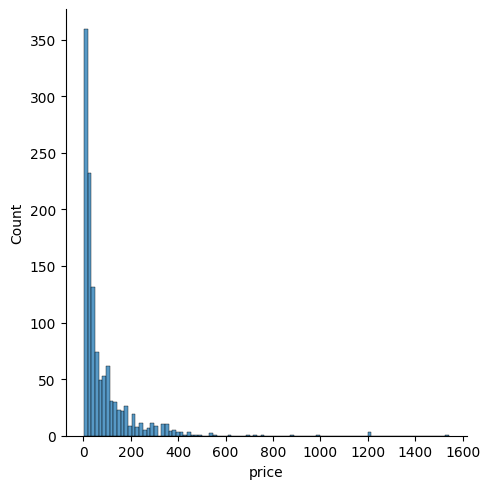

In [10]:
sns.displot(y)

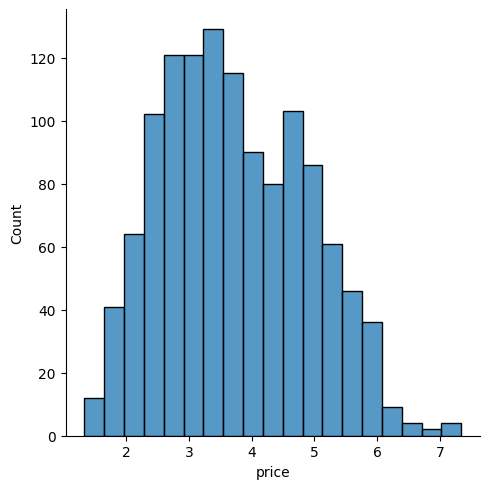

In [11]:
sns.displot(np.log1p(y))

In [12]:
y = np.log1p(y)

In [13]:
cat_features = list()

for col_name, dtype in data.dtypes.to_dict().items():
    if dtype == "object":
        cat_features.append(col_name)

cat_features

['author',
 'author_type',
 'location',
 'deal_type',
 'accommodation_type',
 'district',
 'street',
 'underground',
 'residential_complex']

In [14]:
n_splits = 5

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
kf.get_n_splits(X, y)
mae = 0

for i, (train_index, val_index) in enumerate(kf.split(X, y)):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_val = X.iloc[val_index]
    y_val = y.iloc[val_index]

    model = CatBoostRegressor(
        iterations=5000,
        cat_features=cat_features,
        eval_metric="MAE",
        learning_rate=0.05,
        verbose=500,
        early_stopping_rounds=500,
    )

    model.fit(X_train, y_train, eval_set=(X_val, y_val))

    preds = model.predict(X_val)
    mae += mean_absolute_error(np.expm1(y_val), np.expm1(preds))

    preds_test = model.predict(test)
    preds_test = [max(np.expm1(pred), 2.805) for pred in preds_test]
    sample_submission["price"] += preds_test

mae / n_splits

0:	learn: 0.9162484	test: 0.9564411	best: 0.9564411 (0)	total: 51ms	remaining: 4m 15s
500:	learn: 0.1387608	test: 0.2149168	best: 0.2149168 (500)	total: 799ms	remaining: 7.18s
1000:	learn: 0.0867868	test: 0.2083379	best: 0.2083379 (1000)	total: 1.55s	remaining: 6.2s
1500:	learn: 0.0593728	test: 0.2063708	best: 0.2062489 (1486)	total: 2.33s	remaining: 5.43s
2000:	learn: 0.0422657	test: 0.2056471	best: 0.2054916 (1977)	total: 3.11s	remaining: 4.66s
2500:	learn: 0.0316446	test: 0.2057555	best: 0.2053767 (2063)	total: 3.9s	remaining: 3.9s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2053767411
bestIteration = 2063

Shrink model to first 2064 iterations.
0:	learn: 0.9097640	test: 0.9818311	best: 0.9818311 (0)	total: 2.38ms	remaining: 11.9s
500:	learn: 0.1360208	test: 0.2465439	best: 0.2464539 (498)	total: 777ms	remaining: 6.98s
1000:	learn: 0.0879211	test: 0.2368045	best: 0.2364677 (990)	total: 1.55s	remaining: 6.21s
1500:	learn: 0.0604029	test: 0.2338401	best: 0.233

22.310519236797084

In [15]:
(60 - mae / n_splits) / 3.75

10.050528203520777

In [17]:
sample_submission["price"] /= n_splits

In [18]:
save_path = "./data/house_prices/submissions/sub_5.csv"
sample_submission.to_csv(save_path)